# Problem 2: Attention Basics - Interactive Notebook

This notebook helps you explore and visualize basic attention mechanisms interactively.

## Setup

In [1]:
import sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import your solution
# When finished, uncomment the following sentence and import your own solution
from solution import SimpleAttention
# from problem import SimpleAttention

# Set random seed for reproducibility
torch.manual_seed(42)

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Setup complete!")

Setup complete!


## Create Attention Module

In [2]:
# Create attention module
n_embd = 64
attn = SimpleAttention(n_embd=n_embd)
attn.eval()  # Disable dropout for visualization

print(attn)
print(f"\nTotal parameters: {sum(p.numel() for p in attn.parameters()):,}")

SimpleAttention(
  (query): Linear(in_features=64, out_features=64, bias=True)
  (key): Linear(in_features=64, out_features=64, bias=True)
  (value): Linear(in_features=64, out_features=64, bias=True)
)

Total parameters: 12,480


## Test Forward Pass

In [3]:
# Create sample input
batch_size = 1
seq_len = 8
x = torch.randn(batch_size, seq_len, n_embd)

print(f"Input shape: {x.shape}")

# Forward pass
with torch.no_grad():
    output = attn(x)

print(f"Output shape: {output.shape}")
print(f"✓ Shape preserved: {x.shape} → {output.shape}")

Input shape: torch.Size([1, 8, 64])
Output shape: torch.Size([1, 8, 64])
✓ Shape preserved: torch.Size([1, 8, 64]) → torch.Size([1, 8, 64])


## Visualize Q, K, V Projections

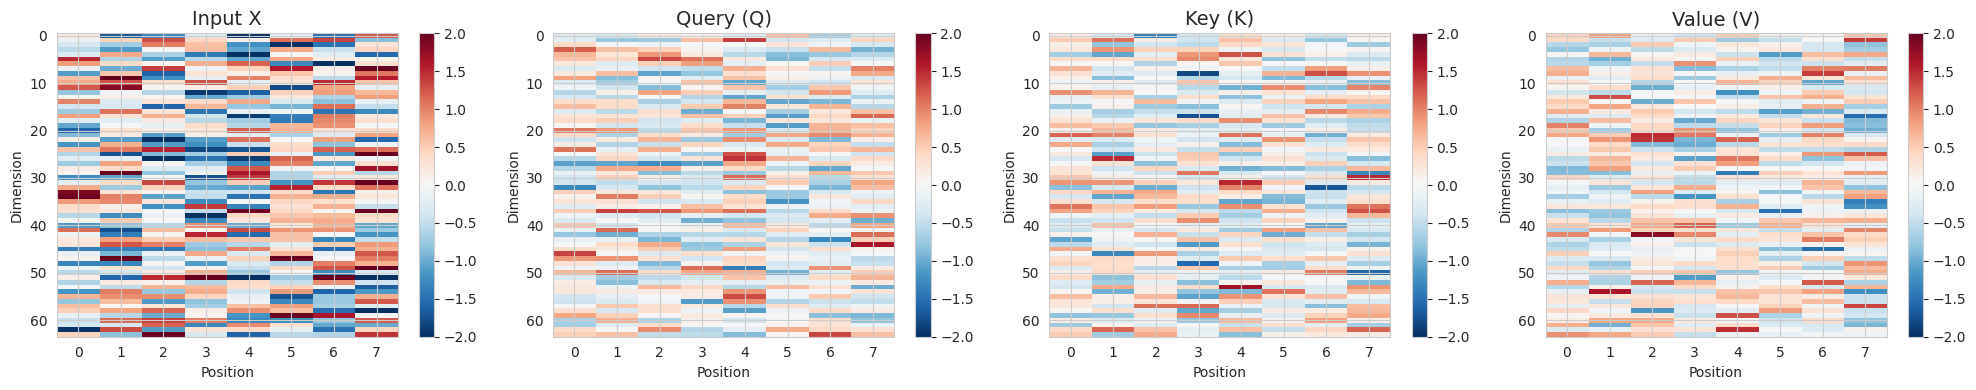

Q, K, V are linear projections of the input!


In [4]:
# Extract Q, K, V for visualization
with torch.no_grad():
    q = attn.query(x)  # (batch, seq_len, n_embd)
    k = attn.key(x)
    v = attn.value(x)

# Plot Q, K, V
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

data = [x.squeeze().numpy(), q.squeeze().numpy(), k.squeeze().numpy(), v.squeeze().numpy()]
titles = ['Input X', 'Query (Q)', 'Key (K)', 'Value (V)']

for ax, d, title in zip(axes, data, titles):
    im = ax.imshow(d.T, aspect='auto', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Position')
    ax.set_ylabel('Dimension')
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

print("Q, K, V are linear projections of the input!")

## Visualize Attention Scores (Q @ K^T)

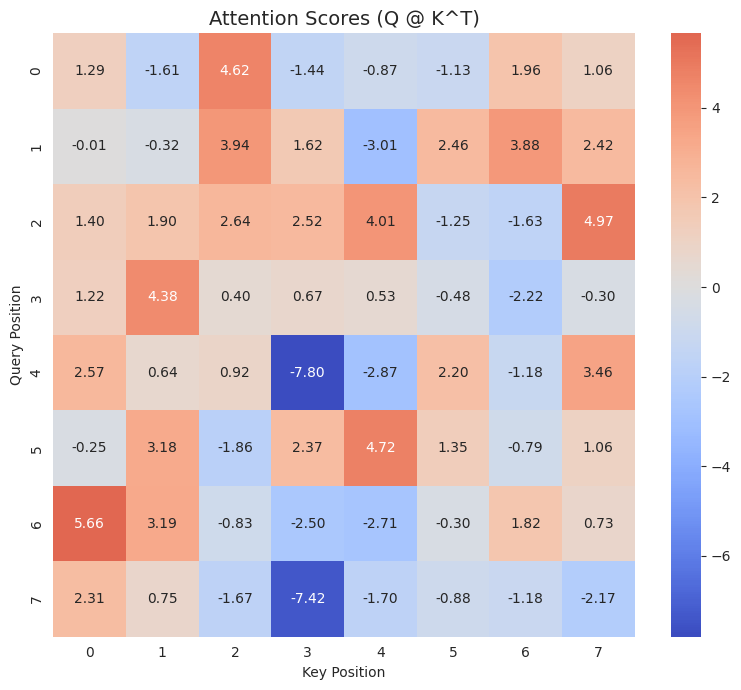

Each query position computes a score with every key position!


In [5]:
# Compute attention scores
with torch.no_grad():
    q = attn.query(x)
    k = attn.key(x)
    
    # Attention scores: Q @ K^T
    attn_scores = q @ k.transpose(-2, -1)  # (batch, seq_len, seq_len)

# Visualize attention scores
plt.figure(figsize=(8, 7))
sns.heatmap(attn_scores.squeeze().numpy(), 
            annot=True, fmt='.2f', 
            cmap='coolwarm', center=0,
            xticklabels=range(seq_len),
            yticklabels=range(seq_len))
plt.title('Attention Scores (Q @ K^T)', fontsize=14)
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.tight_layout()
plt.show()

print("Each query position computes a score with every key position!")

## Visualize Attention Weights (After Softmax)

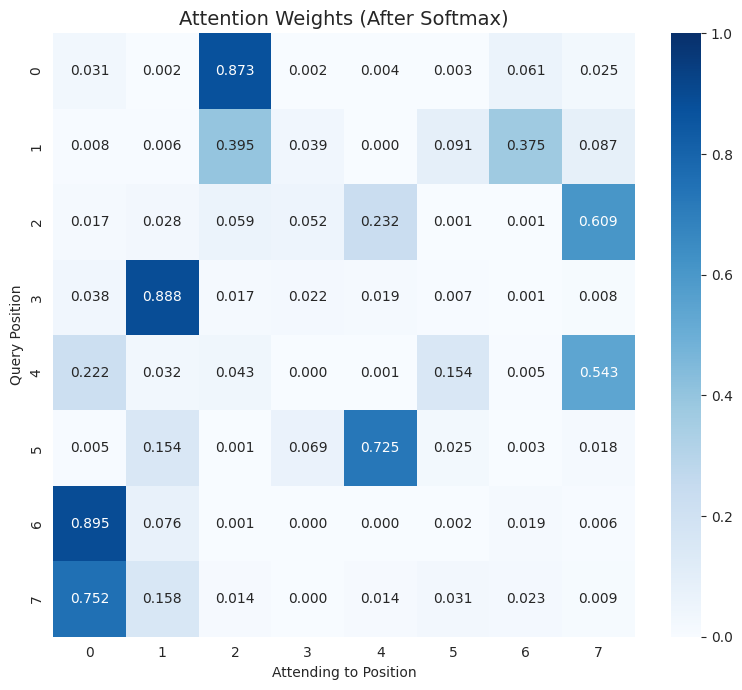


Row sums (should all be 1.0): [0.99999994 1.         1.         1.         1.         1.
 1.         1.        ]
✓ Each query attends to all positions with weights summing to 1!


In [6]:
# Compute attention weights
with torch.no_grad():
    q = attn.query(x)
    k = attn.key(x)
    
    attn_scores = q @ k.transpose(-2, -1)
    attn_weights = torch.softmax(attn_scores, dim=-1)  # Normalize with softmax

# Visualize attention weights
plt.figure(figsize=(8, 7))
sns.heatmap(attn_weights.squeeze().numpy(), 
            annot=True, fmt='.3f', 
            cmap='Blues', vmin=0, vmax=1,
            xticklabels=range(seq_len),
            yticklabels=range(seq_len))
plt.title('Attention Weights (After Softmax)', fontsize=14)
plt.xlabel('Attending to Position')
plt.ylabel('Query Position')
plt.tight_layout()
plt.show()

# Verify rows sum to 1
row_sums = attn_weights.squeeze().sum(dim=-1)
print(f"\nRow sums (should all be 1.0): {row_sums.numpy()}")
print("✓ Each query attends to all positions with weights summing to 1!")

## Compare Different Positions' Attention Patterns

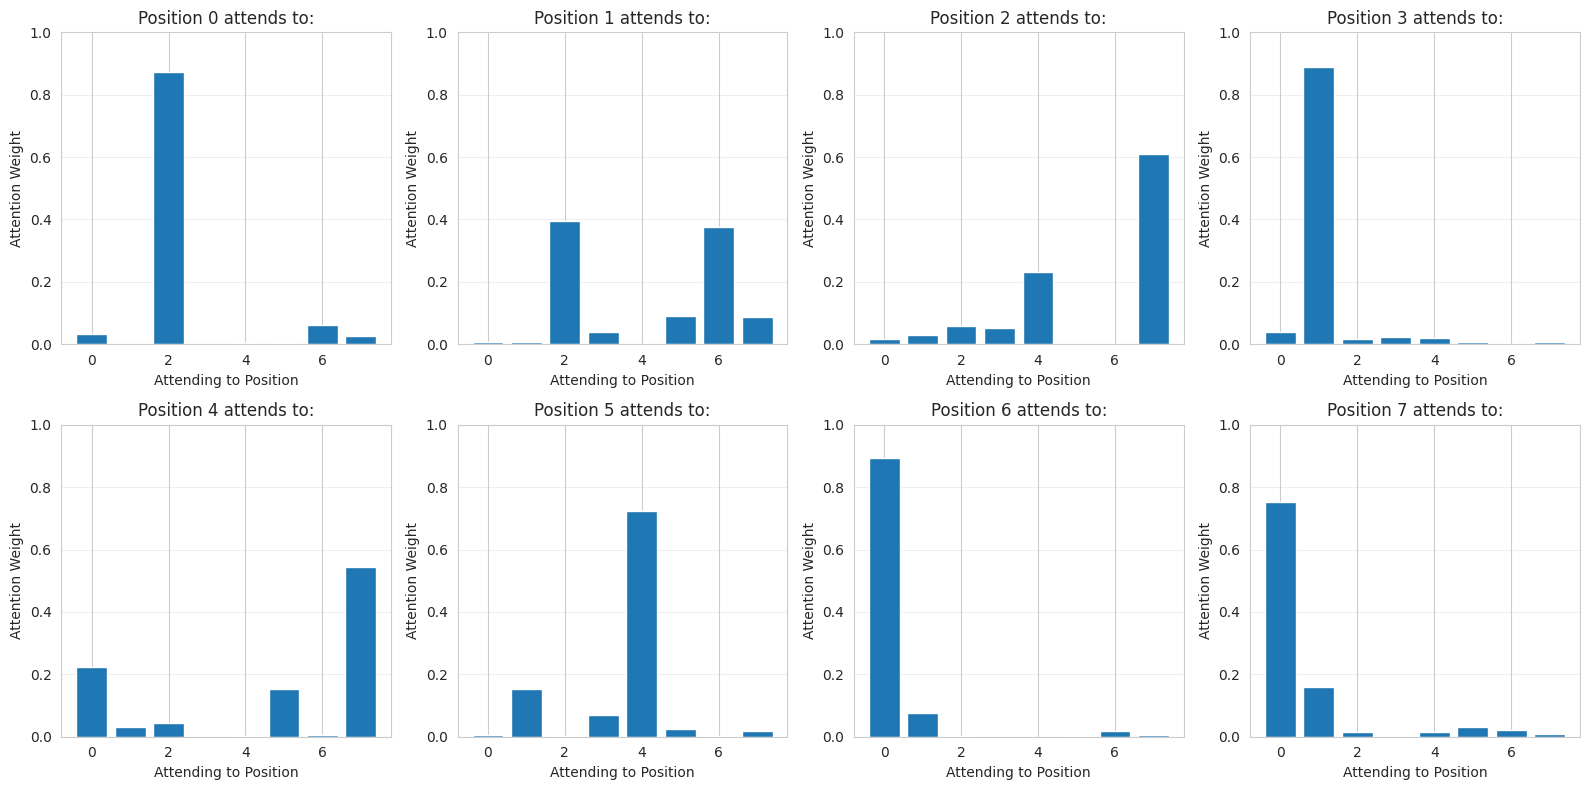

Each position has its own attention pattern!


In [7]:
# Plot attention weights for each position
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

attn_weights_np = attn_weights.squeeze().numpy()

for pos in range(seq_len):
    axes[pos].bar(range(seq_len), attn_weights_np[pos])
    axes[pos].set_title(f'Position {pos} attends to:', fontsize=12)
    axes[pos].set_xlabel('Attending to Position')
    axes[pos].set_ylabel('Attention Weight')
    axes[pos].set_ylim([0, 1])
    axes[pos].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Each position has its own attention pattern!")

## Visualize Full Attention Process

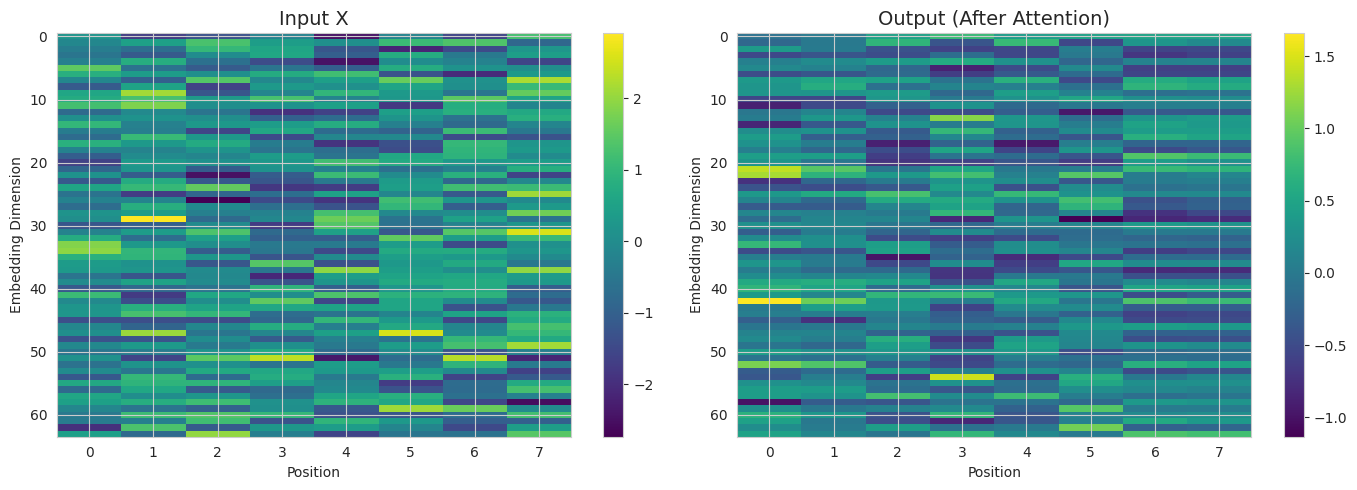

Attention transforms the input based on relationships between positions!


In [8]:
# Complete attention computation
with torch.no_grad():
    q = attn.query(x)
    k = attn.key(x)
    v = attn.value(x)
    
    attn_scores = q @ k.transpose(-2, -1)
    attn_weights = torch.softmax(attn_scores, dim=-1)
    output = attn_weights @ v  # Apply attention to values

# Plot input vs output
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im1 = axes[0].imshow(x.squeeze().T.numpy(), aspect='auto', cmap='viridis')
axes[0].set_title('Input X', fontsize=14)
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Embedding Dimension')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(output.squeeze().T.numpy(), aspect='auto', cmap='viridis')
axes[1].set_title('Output (After Attention)', fontsize=14)
axes[1].set_xlabel('Position')
axes[1].set_ylabel('Embedding Dimension')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print("Attention transforms the input based on relationships between positions!")

## Experiment: Effect of Sequence Length

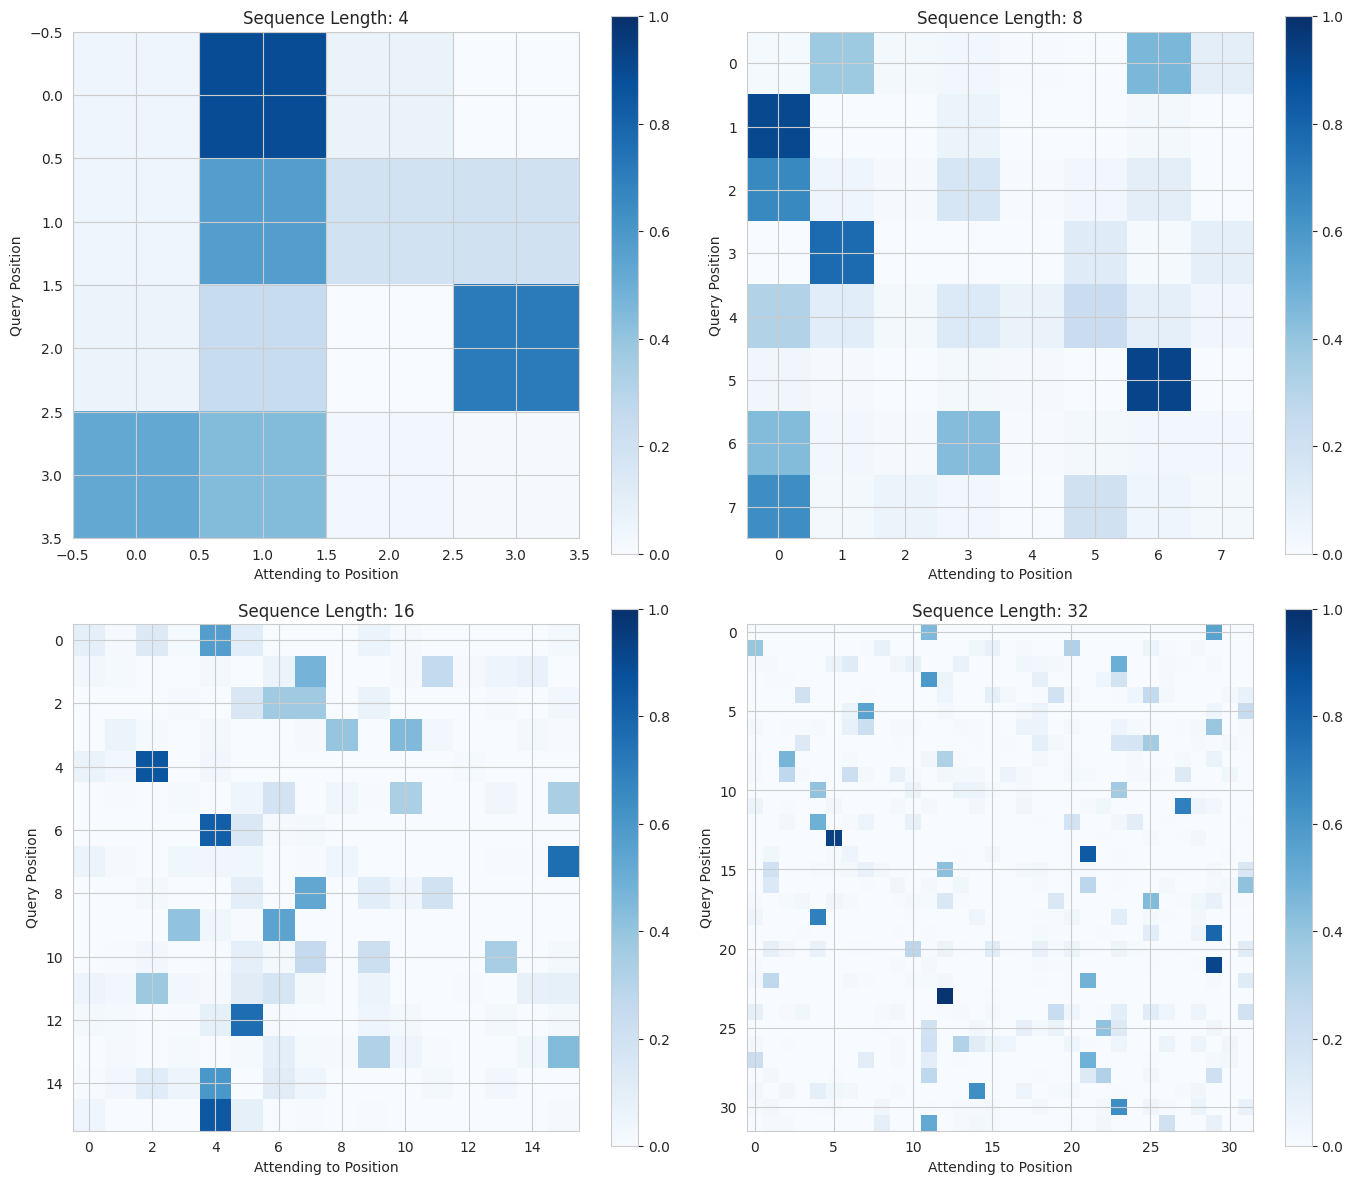

Attention works with any sequence length!


In [9]:
# Test with different sequence lengths
seq_lengths = [4, 8, 16, 32]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, seq_len in enumerate(seq_lengths):
    x_test = torch.randn(1, seq_len, n_embd)
    
    with torch.no_grad():
        q = attn.query(x_test)
        k = attn.key(x_test)
        attn_scores = q @ k.transpose(-2, -1)
        attn_weights = torch.softmax(attn_scores, dim=-1)
    
    im = axes[idx].imshow(attn_weights.squeeze().numpy(), 
                          cmap='Blues', vmin=0, vmax=1)
    axes[idx].set_title(f'Sequence Length: {seq_len}', fontsize=12)
    axes[idx].set_xlabel('Attending to Position')
    axes[idx].set_ylabel('Query Position')
    plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()

print("Attention works with any sequence length!")

## Understand: What Does Attention Do?

In [10]:
# Create interpretable example
seq_len = 5
x_simple = torch.randn(1, seq_len, n_embd)

with torch.no_grad():
    q = attn.query(x_simple)
    k = attn.key(x_simple)
    v = attn.value(x_simple)
    
    attn_scores = q @ k.transpose(-2, -1)
    attn_weights = torch.softmax(attn_scores, dim=-1)
    output = attn_weights @ v

# Show how one position's output is computed
pos = 2
print(f"\n=== Computing output for Position {pos} ===")
print(f"\nAttention weights for position {pos}:")
weights = attn_weights.squeeze()[pos].numpy()
for i, w in enumerate(weights):
    print(f"  Position {i}: {w:.3f}")

print(f"\nOutput[{pos}] = weighted sum of all Values:")
print(f"  = {weights[0]:.3f} × V[0] + {weights[1]:.3f} × V[1] + ... + {weights[4]:.3f} × V[4]")
print(f"\nThis is how attention allows positions to gather information from other positions!")


=== Computing output for Position 2 ===

Attention weights for position 2:
  Position 0: 0.080
  Position 1: 0.425
  Position 2: 0.088
  Position 3: 0.001
  Position 4: 0.406

Output[2] = weighted sum of all Values:
  = 0.080 × V[0] + 0.425 × V[1] + ... + 0.406 × V[4]

This is how attention allows positions to gather information from other positions!


## Verify Your Implementation

Run the tests to make sure everything works!

In [11]:
# Quick verification
attn = SimpleAttention(n_embd=768)
x = torch.randn(2, 10, 768)
output = attn(x)

print("✓ Module initializes correctly")
print(f"✓ Forward pass works: {x.shape} → {output.shape}")
print(f"✓ Shape preserved: {x.shape == output.shape}")
print("\n✅ Basic functionality verified!")
print("\nRun 'python -m pytest test_attention.py -v' for complete validation.")

✓ Module initializes correctly
✓ Forward pass works: torch.Size([2, 10, 768]) → torch.Size([2, 10, 768])
✓ Shape preserved: True

✅ Basic functionality verified!

Run 'python -m pytest test_attention.py -v' for complete validation.
